# SVM baseline (QSAR) — feature selection + calibration

This notebook mirrors the structure of the XGBoost baseline but uses **SVM (RBF kernel)** with a simple univariate feature ranking to pick **Top-N** descriptors. It then trains a calibrated SVM, reports **Accuracy/F1/ROC-AUC**, saves the selected features, and plots the ROC curve.

> Expected inputs (same shape as in the XGB notebook):
>
> - `X_1D2D_descriptors.csv` — numeric descriptors matrix (samples × features)
> - `in_chemico_dataset.xlsx` — original labels table with column `Phototoxicity` (0/1)

You can adjust file names and target column below.


In [20]:
# If needed, install deps (uncomment to run in a fresh environment)
# !pip install -q pandas numpy scikit-learn matplotlib openpyxl joblib

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest,
    SelectFromModel,
    f_classif,
    mutual_info_classif,
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, LinearSVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from joblib import dump

# Make output deterministic
np.random.seed(42)

In [22]:
# ==== Config ====
DESC_CSV = "X_1D2D_descriptors.csv"
ORIG_XLSX = "in_chemico_dataset.xlsx"
TARGET_COL = "Phototoxicity"
EXCEL_SKIPROWS = 1

# Output
TOP_FEATURES_CSV = "svm_top_features_best.csv"
FINAL_MODEL_PATH = "svm_final_model.joblib"
FEATURE_RANKING_CSV = "svm_feature_ranking.csv"

# Feature ranking method: 'f_classif' or 'mutual_predict_proba_from_descriptorsinfo'
RANK_METHOD = "mutual_info"

# Train-test split
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Range of Top-N features to try (inclusive of start, exclusive of stop, step 1)
N_START, N_STOP = 5, 120

In [33]:
# ==== Load data ====
X = pd.read_csv(DESC_CSV)
y = pd.read_excel(ORIG_XLSX, engine="openpyxl", skiprows=EXCEL_SKIPROWS)[
    TARGET_COL
].astype(int)

# Align on the index if needed
if len(X) != len(y):
    min_len = min(len(X), len(y))
    X = X.iloc[:min_len].reset_index(drop=True)
    y = y.iloc[:min_len].reset_index(drop=True)

print(f"X shape: {X.shape}")
print(f"y value counts:\n{y.value_counts()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

X shape: (162, 191)
y value counts:
Phototoxicity
1    87
0    75
Name: count, dtype: int64
Train: (129, 191), Test: (33, 191)


## Feature ranking


In [24]:
# import numpy as np, pandas as pd, sklearn
# from sklearn.svm import LinearSVC, SVC
# from sklearn.feature_selection import SelectFromModel
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.model_selection import StratifiedKFold, GridSearchCV

# # --- Pipeline ---
# pipeline = Pipeline(
#     [
#         ("scaler", StandardScaler()),
#         (
#             "select",
#             SelectFromModel(
#                 estimator=LinearSVC(
#                     penalty="l1",
#                     dual=False,
#                     C=1.0,
#                     class_weight="balanced",
#                     max_iter=5000,
#                     random_state=42,
#                 ),
#                 threshold="median",
#             ),
#         ),
#         (
#             "clf",
#             CalibratedClassifierCV(
#                 estimator=SVC(kernel="rbf", class_weight="balanced"),
#                 method="sigmoid",
#                 cv=5,
#             ),
#         ),
#     ]
# )

# param_grid = {
#     "select__estimator__C": [0.1, 0.5, 1, 2, 5],
#     "clf__estimator__C": [0.5, 1, 2, 5, 10],
#     "clf__estimator__gamma": ["scale", 0.01, 0.001],
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid = GridSearchCV(pipeline, param_grid, scoring="f1", cv=cv, n_jobs=-1)
# grid.fit(X, y)

# best_clf = grid.best_estimator_
# mask = best_clf.named_steps["select"].get_support()
# selected_features = X.columns[mask]
# # print("Vybrané features:", list(selected_features))
# selected_features

In [25]:
# ==== Feature ranking ====
if RANK_METHOD == "f_classif":
    # ANOVA F-score (fast baseline)
    selector_full = SelectKBest(score_func=f_classif, k="all")
    selector_full.fit(X_train, y_train)
    scores = selector_full.scores_
elif RANK_METHOD == "mutual_info":
    # Mutual information (slower, non-linear)
    scores = mutual_info_classif(X_train, y_train, random_state=RANDOM_STATE)
else:
    raise ValueError("Unsupported RANK_METHOD")

feat_imp = (
    pd.DataFrame({"feature": X_train.columns, "score": scores})
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)

feat_imp.to_csv(FEATURE_RANKING_CSV, index=False)
print(f"Saved feature ranking -> {FEATURE_RANKING_CSV}")
feat_imp.head()

Saved feature ranking -> svm_feature_ranking.csv


,feature,score
0,SlogP_VSA6,0.176561
1,MaxAbsEStateIndex,0.176432
2,MaxEStateIndex,0.174881
3,SlogP_VSA8,0.168110
4,EState_VSA3,0.160058


In [26]:
# ==== Model sweep over Top-N features ====
results = []


# Base SVM model (RBF). We'll calibrate via CalibratedClassifierCV for proper probabilities.
def make_base_model(C=1.0, gamma="scale"):
    svc = SVC(
        kernel="rbf",
        C=C,
        gamma=gamma,
        class_weight="balanced",
        probability=False,
        random_state=RANDOM_STATE,
    )
    # Note: CalibratedClassifierCV performs internal CV to learn calibration
    model = Pipeline(
        [
            ("scale", StandardScaler(with_mean=True, with_std=True)),
            ("svc", svc),
        ]
    )
    return model


# Simple hyperparams (can expand later)
C_grid = [0.1, 1.0, 10.0]
gamma_grid = ["scale", 0.01, 0.001]

for n in range(N_START, N_STOP, 1):
    top_feats = feat_imp["feature"].head(n).tolist()
    best_tuple = None
    best_f1 = -np.inf

    # Quick grid-search (hold-out) on train split to pick C/gamma by F1
    for C in C_grid:
        for gamma in gamma_grid:
            base = make_base_model(C=C, gamma=gamma)
            base.fit(X_train[top_feats], y_train)

            # Calibrate on train via CV
            calib = CalibratedClassifierCV(base, method="isotonic", cv=3)
            calib.fit(X_train[top_feats], y_train)

            y_pred = (calib.predict_proba(X_test[top_feats])[:, 1] >= 0.5).astype(int)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            try:
                roc = roc_auc_score(
                    y_test, calib.predict_proba(X_test[top_feats])[:, 1]
                )
            except ValueError:
                roc = np.nan

            if f1 > best_f1:
                best_f1 = f1
                best_tuple = (acc, f1, roc, C, gamma)

    acc, f1, roc, C_star, gamma_star = best_tuple
    results.append((n, acc, f1, roc, C_star, gamma_star))

res_df = pd.DataFrame(
    results, columns=["Top_N", "Accuracy", "F1", "ROC_AUC", "C", "gamma"]
)
res_df.head()

,Top_N,Accuracy,F1,ROC_AUC,C,gamma
0,5,0.575758,0.611111,0.688889,1.0,0.01
1,6,0.666667,0.666667,0.679630,10.0,scale
2,7,0.696970,0.705882,0.696296,10.0,scale
3,8,0.727273,0.756757,0.761111,0.1,scale
4,9,0.727273,0.769231,0.809259,10.0,scale


In [27]:
# ==== Select best Top-N by F1 and save ====
best = res_df.iloc[res_df["F1"].idxmax()]
best_n = int(best.Top_N)
best_C = best.C
best_gamma = best.gamma
print(
    f"Best N={best_n}, C={best_C}, gamma={best_gamma} -> Acc={best.Accuracy:.3f}, F1={best.F1:.3f}, ROC_AUC={best.ROC_AUC:.3f}"
)

best_feats = feat_imp.head(best_n)
best_feats.to_csv(TOP_FEATURES_CSV, index=False)
print(f"Saved top {best_n} features -> {TOP_FEATURES_CSV}")

Best N=74, C=10.0, gamma=0.01 -> Acc=0.788, F1=0.800, ROC_AUC=0.831
Saved top 74 features -> svm_top_features_best.csv


Final (Test) -> Acc=0.788 | F1=0.800 | ROC-AUC=0.831


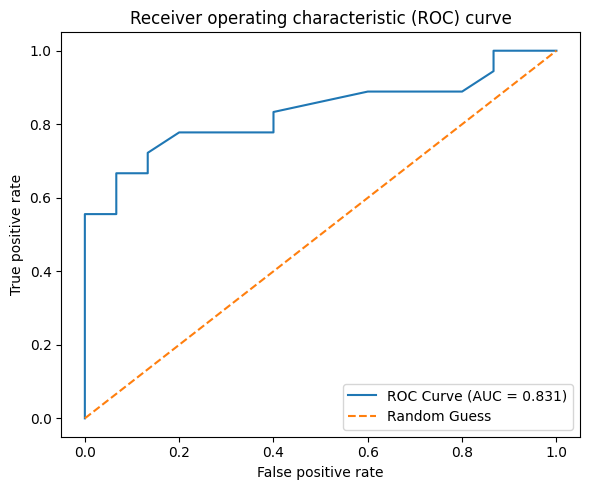

In [28]:
# ==== Train final calibrated SVM on best Top-N ====
top_feats = feat_imp["feature"].head(best_n).tolist()

final_base = Pipeline(
    [
        ("scale", StandardScaler()),
        (
            "svc",
            SVC(
                kernel="rbf",
                C=best_C,
                gamma=best_gamma,
                class_weight="balanced",
                probability=False,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

calib = CalibratedClassifierCV(final_base, method="isotonic", cv=3)
calib.fit(X_train[top_feats], y_train)

y_prob = calib.predict_proba(X_test[top_feats])[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"Final (Test) -> Acc={acc:.3f} | F1={f1:.3f} | ROC-AUC={auc:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver operating characteristic (ROC) curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [29]:
# ==== Save calibrated model ====
dump(
    {
        "model": calib,
        "top_features": top_feats,
        "config": {
            "C": best_C,
            "gamma": best_gamma,
            "rank_method": RANK_METHOD,
            "desc_csv": DESC_CSV,
            "orig_xlsx": ORIG_XLSX,
            "target_col": TARGET_COL,
            "excel_skiprows": EXCEL_SKIPROWS,
            "random_state": RANDOM_STATE,
        },
    },
    FINAL_MODEL_PATH,
)

print(f"Saved final calibrated SVM -> {FINAL_MODEL_PATH}")

Saved final calibrated SVM -> svm_final_model.joblib


In [30]:
# ==== Inference helper ====
import numpy as np
from joblib import load

bundle = load(FINAL_MODEL_PATH)
clf = bundle["model"]
top_features = bundle["top_features"]


def predict_proba_from_descriptors(df_desc: pd.DataFrame) -> np.ndarray:
    missing = [f for f in top_features if f not in df_desc.columns]
    if missing:
        raise ValueError(
            f"Missing required features: {missing[:10]}"
            + ("..." if len(missing) > 10 else "")
        )
    return clf.predict_proba(df_desc[top_features])[:, 1]


# Example (commented):
# X_new = pd.read_csv("X_1D2D_descriptors_new.csv")
# p = predict_proba_from_descriptors(X_new)
# pd.DataFrame({"p_toxic": p}).head()

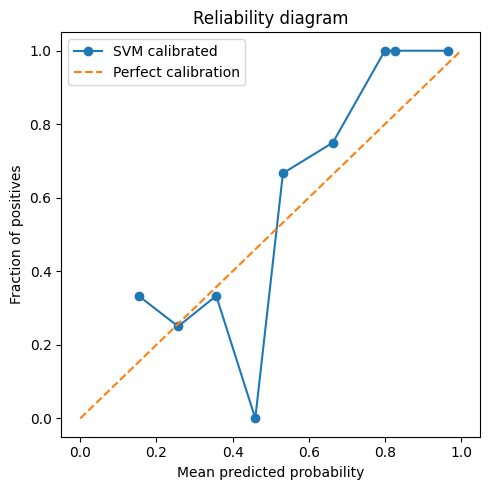

In [31]:
# ==== Optional: Reliability diagram (calibration curve) ====
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="uniform")
plt.figure(figsize=(5, 5))
plt.plot(prob_pred, prob_true, marker="o", label="SVM calibrated")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability diagram")
plt.legend()
plt.tight_layout()
plt.show()

### Notes / tips

- Scale of features matters for SVM; hence the `StandardScaler` in the pipeline.
- We use **CalibratedClassifierCV** (isotonic) for well-behaved probabilities (for PR/ROC and thresholding).
- The feature ranking step is **univariate** and fast. If needed, replace with **RFE** using a linear SVM for a wrapper-style selection.
- For larger datasets, SVM (RBF) may be slower. Consider narrowing the Top-N or trying a **linear SVM** (`LinearSVC`) + calibration.
- Keep the same data cleaning and target preparation steps you used for the XGBoost baseline to ensure comparability.
